In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')
from keras import Sequential
from keras.src.layers import LSTM, Dense, Dropout

# Đọc dữ liệu từ file CSV
data = pd.read_csv('./clean data/z')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Tạo thêm các đặc trưng mới cho bộ dữ liệu
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [0, 1]
data['Have_Increase'] = np.select(conditions, values, default = 1)

newfeatures = pd.DataFrame()
newfeatures['Target'] = data["Close"].rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])
newfeatures['Target'].fillna(0, inplace=True)
data = data.shift(1)
data['Target'] = newfeatures['Target']
data = data.iloc[1:]

weekly_mean = data['Close'].rolling(window=7).mean()
quarterly_mean = data['Close'].rolling(window=90).mean()
annual_mean = data['Close'].rolling(window=365).mean()
data['weekly_mean'] = weekly_mean / data['Close']
data['quarterly_mean'] = quarterly_mean / data['Close']
data['annual_mean'] = annual_mean / data['Close']
data['open_close_ratio'] = data['Open'] / data['Close']
data['high_close_ratio'] = data['High'] / data['Close']
data['low_close_ratio'] = data['Low'] / data['Close']

# Chọn các đặc trưng cho mô hình Logistic và Random Forest
predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
full_predictors = predictors + ['Have_Increase','weekly_mean', 'quarterly_mean', 'annual_mean', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']

# Chia dữ liệu thành tập huấn luyện và kiểm tra cho mô hình LSTM
dataset_train = data.iloc[0:int(0.8*len(data)), :]
dataset_test = data.iloc[int(0.8*len(data)):, :]

# Lấy cột 'Close' để dự báo
training_set = data['Close'].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Tạo cấu trúc dữ liệu với 7 bước thời gian và 1 output
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

time_step = 7
X_train, y_train = create_dataset(training_set_scaled[:len(dataset_train)], time_step)
X_test, y_test = create_dataset(training_set_scaled[len(dataset_train)-time_step:], time_step)

# Reshape dữ liệu để phù hợp với LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Dự báo trên tập kiểm tra
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Dự báo trên tập huấn luyện
train_predict = model.predict(X_train)
train_predict = sc.inverse_transform(train_predict)

# Tính toán lỗi RMSE
rmse_train = math.sqrt(mean_squared_error(data['Close'][:len(train_predict)], train_predict))
rmse_test = math.sqrt(mean_squared_error(data['Close'][len(train_predict)+time_step:], predicted_stock_price))

print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0489
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4583e-04
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5191e-04
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2414e-04
Epoch 9/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3169e-04
Epoch 10/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9482e-04
Epoch 11/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8415e-04
Epoch 12/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7177e-04
Epoch 13/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3383e-04
Epoch 14/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3632e-04
Epoch 15/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

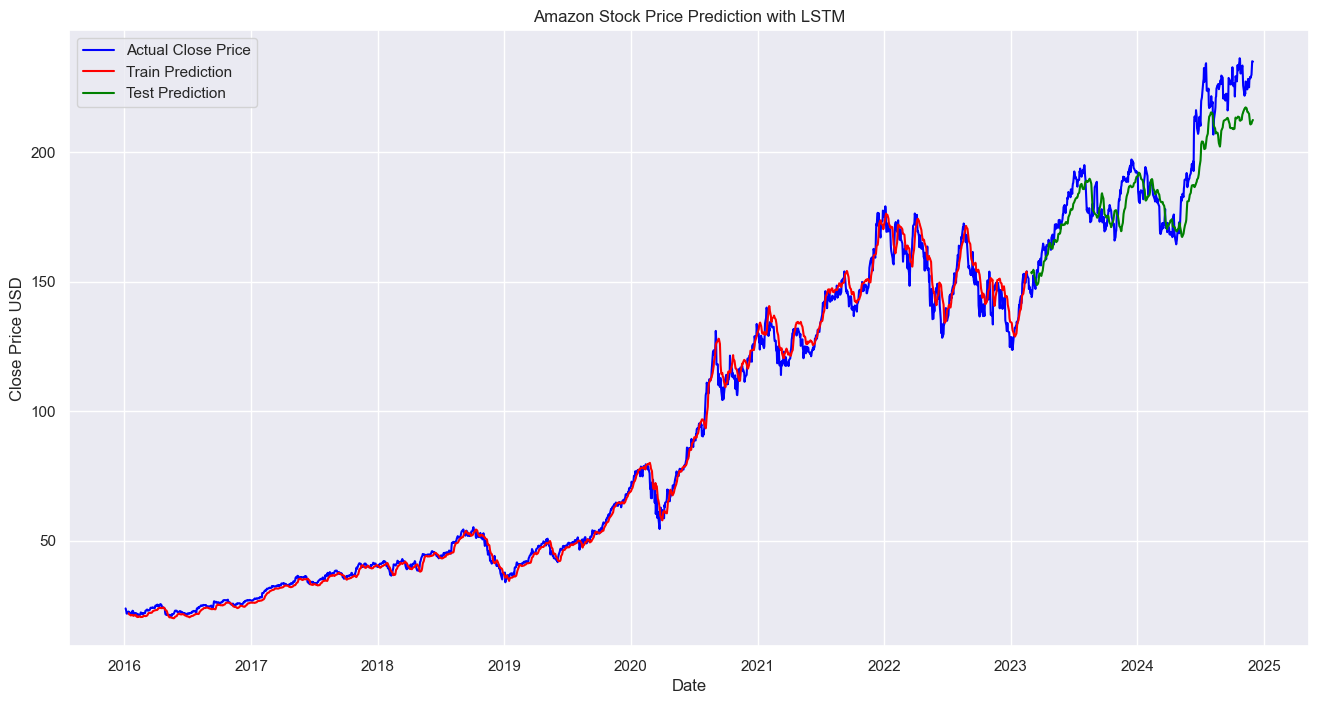

In [2]:
train_predict_plot = np.empty_like(data['Close'])
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict[:, 0]

test_predict_plot = np.empty_like(data['Close'])
test_predict_plot[:] = np.nan

# Điều chỉnh giới hạn của test_predict_plot để khớp kích thước với predicted_stock_price
test_predict_len = len(data) - (len(train_predict) + (time_step*2))
test_predict_plot[len(train_predict) + (time_step*2): len(train_predict) + (time_step*2) + test_predict_len] = predicted_stock_price[:test_predict_len, 0]

plt.figure(figsize=(16, 8))
plt.plot(data['Close'], color='blue', label='Actual Close Price')
plt.plot(data.index, train_predict_plot, color='red', label='Train Prediction')
plt.plot(data.index, test_predict_plot, color='green', label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.title('Amazon Stock Price Prediction with LSTM')
plt.legend()
plt.show()
